<a href="https://colab.research.google.com/github/npl0204/LSTM-RNN-Beer-Wine-and-Distilled-Alcoholic-Beverages-Sales/blob/main/LSTM_RNN_for_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM
---

**LSTM** is a variant of RNN used in deep learning, can be used LSTMs when working on sequences of data.
* Time series forecasting (for example, stock prediction)
* Text generation
* Video classification
* Music generation
* Anomaly detection

**RNNs** are neural networks that are good with sequential data. It can be video, audio, text, stock market time series or even a single image cut into a sequence of its parts.

*Compare:* Standard neural networks (convolutional or vanilla) have one major shortcoming when compared to RNNs - they cannot reason about previous inputs to inform later ones.

**LSTM vs RNN**
* Typical RNNs can't memorize long sequences. The effect called “vanishing gradients” happens during the backpropagation phase of the RNN cell network. The gradients of cells that carry information from the start of a sequence goes through matrix multiplications by small numbers and reach close to 0 in long sequences. In other words - information at the start of the sequence has almost no effect at the end of the sequence.
* LSTM is an RNN architecture that can memorize long sequences - up to 100s of elements in a sequence. LSTM has a memory gating mechanism that allows the long term memory to continue flowing into the LSTM cells.

## Import Package and Load Dataset
---

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

In [23]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random 

This relates to plotting datetime values with matplotlib

In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [25]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Logistic Regression/Alcohol_Sales.csv", index_col=0, parse_dates=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For Time Series data -> better to remove N/A

In [26]:
df.dropna(inplace=True)
len(df)

367

In [27]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [28]:
df.tail()

,S4248SM144NCEN
DATE,
2022-03-01,16165
2022-04-01,15584
2022-05-01,16600
2022-06-01,17700
2022-07-01,15112


## Plotting Time Series
---

Tighten the x-axis to fit the width of the actual data with plt.autoscale(axis='x',tight=True).

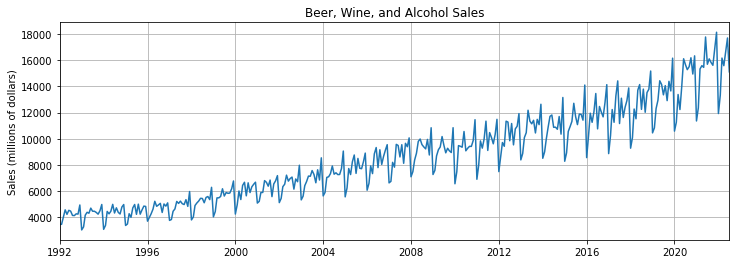

In [29]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare Data
---

### Normalize the training values so that they fall between -1 and 1 (to improve training)

The formula for normalizing data around zero is:<br>
#### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>

Perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
#### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

*NOTE*: 
* Normalize the training set to avoid data leakage. 
* If we include the test set then the higher average values of the test set could become part of the signal in the training set (about <a href='test_set = input_data(test_norm,window_size)'>data leakage</a>).

After using transformed data to train the model and generate predictions, we'll ```inverse_transform``` the predicted values so that we can compare them to the actual test data.

In [30]:
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 36

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

### Prepare data for LSTM

Create list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of training set will become ((```len(df)``` - ```test_size```) - ```window_size```).

In [32]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 36

# Define function to create seq/label tuples
def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        rs = random.randint(0,6)
        if i+ws+rs >= len(seq):
            rs = 0
        window = seq[i:i+ws+rs]
        label = seq[i+ws+rs:i+ws+rs+1]
        out.append((window, label))
    return out

In [33]:
# Apply the input_data function to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)  # this should equal 367-36-12

295

In [34]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9295, -0.9297, -0.8401, -0.7475, -0.8040, -0.7533, -0.7636, -0.8178,
         -0.8196, -0.7977, -0.8009, -0.6862, -1.0000, -0.9621, -0.8140, -0.7783,
         -0.7898, -0.7258, -0.7650, -0.7651, -0.7804, -0.8015, -0.7580, -0.6800,
         -0.9928, -0.9430, -0.7674, -0.7974, -0.7646, -0.6782, -0.7870, -0.7220,
         -0.7788, -0.7996, -0.7113, -0.6805, -0.9442, -0.9254]),
 tensor([-0.7961]))

### Define model with an LSTM layer of size (1, 100)

```torch.zeros```: Returns a tensor filled with the scalar value 0, with the shape defined by the variable argument size. Example: >>> ```torch.zeros(2, 3)``` returns ```tensor([[ 0.,  0.,  0.], [ 0.,  0.,  0.]])```.

In [35]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size, output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        # print('Prediction',pred)
        return pred[-1]  # we only want the last value, label

In [36]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [37]:
def count_parameters(model):
    # torch.numel() returns the total number of elements in the input tensor
    # torch.requires_grad is True if gradients need to be computed for tensor
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(params) 
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

[400, 40000, 400, 400, 100, 1]
   400
 40000
   400
   400
   100
     1
______
 41301


### Train the model

In [38]:
epochs = 500

import time
start_time = time.time()

all_losses = []

for epoch in range(epochs):
    plot_every = 1
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    if epoch % plot_every == 0:
        all_losses.append(loss.detach().numpy())
        
    # print training result
    if epoch % (epochs/10) == 0: 
        print(f'Epoch: {epoch:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  0 Loss: 0.00355396
Epoch: 50 Loss: 0.00011162
Epoch: 100 Loss: 0.00009517
Epoch: 150 Loss: 0.00007701
Epoch: 200 Loss: 0.00000132
Epoch: 250 Loss: 0.00016945
Epoch: 300 Loss: 0.00000048
Epoch: 350 Loss: 0.00013755
Epoch: 400 Loss: 0.00011807
Epoch: 450 Loss: 0.00017236

Duration: 1218 seconds


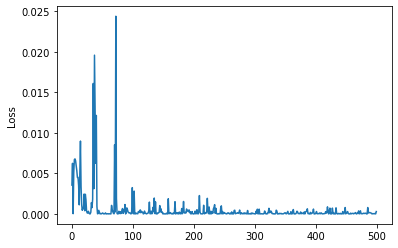

In [39]:
plt.plot(all_losses)
plt.ylabel('Loss')
plt.show()

### Predict into a period that matches the test set

#### Predict testing dataset

In [40]:
future = 36

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.6554811000823975,
 0.6298389434814453,
 0.785607635974884,
 0.7940285205841064,
 1.1225321292877197,
 0.2641045153141022,
 0.42827969789505005,
 0.6766275763511658,
 0.7011831402778625,
 0.8681002855300903,
 0.8965597748756409,
 0.7258642315864563,
 0.6927374601364136,
 0.6451517343521118,
 0.7705912590026855,
 0.8336778283119202,
 1.0637000799179077,
 0.25677719712257385,
 0.40557509660720825,
 0.6271795630455017,
 0.6884797811508179,
 0.8835462927818298,
 0.8428463339805603,
 0.7128686904907227,
 0.6735759973526001,
 0.623356282711029,
 0.7781744599342346,
 0.8318352699279785,
 0.9923557639122009,
 0.26185598969459534,
 0.44905486702919006,
 0.6331037282943726,
 0.7188588976860046,
 0.8941162824630737,
 0.7777568101882935,
 0.7033201456069946]

#### Invert the prediction to normalization using ```inverse_transform```

In [41]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[13082.25349915],
       [12926.56714535],
       [13872.31676182],
       [13923.44416273],
       [15917.95382297],
       [10706.01056473],
       [11702.80018577],
       [13210.64432982],
       [13359.7334362 ],
       [14373.1708836 ],
       [14545.96267316],
       [13509.58468208],
       [13308.45548922],
       [13019.53875512],
       [13781.14482903],
       [14164.1749346 ],
       [15560.75503522],
       [10661.52275233],
       [11564.94919905],
       [12910.42071703],
       [13282.60499126],
       [14466.95131662],
       [14219.84151676],
       [13430.68225431],
       [13192.11666793],
       [12887.20767048],
       [13827.18623349],
       [14152.98784137],
       [15127.58802059],
       [10692.35864143],
       [11828.93662517],
       [12946.38928634],
       [13467.0517973 ],
       [14531.12700897],
       [13824.65047306],
       [13372.70826405]])

In [42]:
# Real value from testing
df['S4248SM144NCEN'][-36:]

DATE
2019-08-01    14058
2019-09-01    12912
2019-10-01    14389
2019-11-01    13652
2019-12-01    16158
2020-01-01    10580
2020-02-01    11267
2020-03-01    13381
2020-04-01    12232
2020-05-01    13997
2020-06-01    16112
2020-07-01    15670
2020-08-01    15281
2020-09-01    15506
2020-10-01    16188
2020-11-01    14946
2020-12-01    16335
2021-01-01    11358
2021-02-01    12369
2021-03-01    15333
2021-04-01    15585
2021-05-01    15455
2021-06-01    17776
2021-07-01    15692
2021-08-01    16104
2021-09-01    15824
2021-10-01    15613
2021-11-01    16896
2021-12-01    18139
2022-01-01    11926
2022-02-01    13333
2022-03-01    16165
2022-04-01    15584
2022-05-01    16600
2022-06-01    17700
2022-07-01    15112
Name: S4248SM144NCEN, dtype: int64

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_set, true_predictions)
mse = mean_squared_error(test_set, true_predictions)
rmse = np.sqrt(mse)  
r2 = r2_score(test_set, true_predictions)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 1627.212785795331
MSE: 3779653.790640366
RMSE: 1944.1331720436144
R-Squared: -0.074223531280317


### Plot the results

Predicted values do not contain a datetime index -> create a range of dates using NumPy that are spaced one month apart using ```dtype='datetime64[M]'```, and then store them with day values to match dataset with ```.astype('datetime64[D]')```.

In [44]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-08-01', '2022-08-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01'],
      dtype='datetime64[D]')

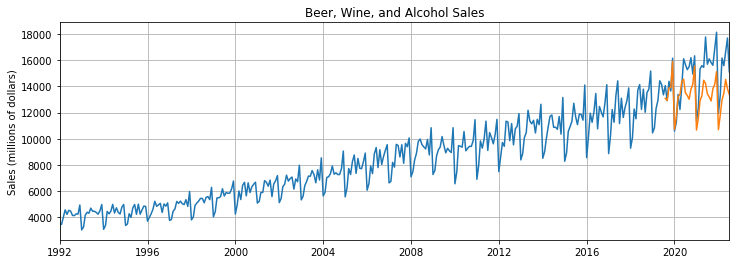

In [45]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

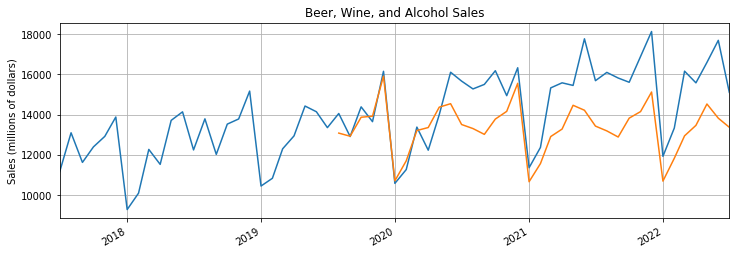

In [46]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-07-01':])
plt.plot(x,true_predictions)
plt.show()

The prediction is close to the actual data. In particular, the prediction keeps the correct pattern of the dataset, in which the trend is unstable during the year but repeated each year.

### Forecast into an unknown future.

Train the model with the whole data.

In [47]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00482367
Epoch:  2 Loss: 0.00700570
Epoch:  3 Loss: 0.00120227
Epoch:  4 Loss: 0.00403171
Epoch:  5 Loss: 0.00015955
Epoch:  6 Loss: 0.00565592
Epoch:  7 Loss: 0.00000560
Epoch:  8 Loss: 0.00585993
Epoch:  9 Loss: 0.00012768
Epoch: 10 Loss: 0.00014421
Epoch: 11 Loss: 0.00002574
Epoch: 12 Loss: 0.00002083
Epoch: 13 Loss: 0.00017257
Epoch: 14 Loss: 0.00012468
Epoch: 15 Loss: 0.00003457
Epoch: 16 Loss: 0.00068939
Epoch: 17 Loss: 0.00080535
Epoch: 18 Loss: 0.00012574
Epoch: 19 Loss: 0.00245206
Epoch: 20 Loss: 0.00000900
Epoch: 21 Loss: 0.01622506
Epoch: 22 Loss: 0.00007550
Epoch: 23 Loss: 0.00045869
Epoch: 24 Loss: 0.00040301
Epoch: 25 Loss: 0.00008982
Epoch: 26 Loss: 0.00048529
Epoch: 27 Loss: 0.00048777
Epoch: 28 Loss: 0.00001174
Epoch: 29 Loss: 0.00039381
Epoch: 30 Loss: 0.00012623
Epoch: 31 Loss: 0.00003052
Epoch: 32 Loss: 0.00004680
Epoch: 33 Loss: 0.00043645
Epoch: 34 Loss: 0.00069843
Epoch: 35 Loss: 0.00052049
Epoch: 36 Loss: 0.00027297
Epoch: 37 Loss: 0.00008675
E

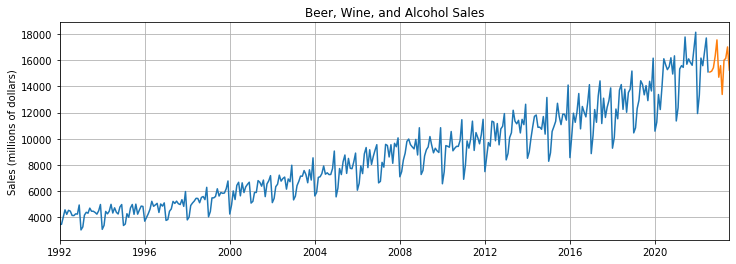

In [48]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2022-08-01', '2023-08-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

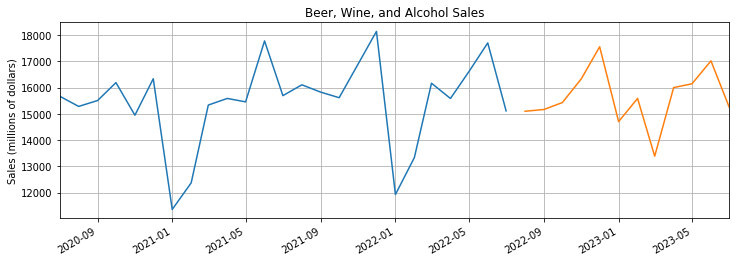

In [49]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2020-07-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

### Bonus

In [50]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv("/content/drive/MyDrive/Logistic Regression/Alcohol_Sales.csv", index_col=0, parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [51]:
# DEFINE A FUNCTION:
def create_train_data(seq, ws=12): #can be changed to 36
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [52]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 367-12-12

343

In [53]:
train_data[0]

(tensor([-0.9419, -0.9421, -0.8683, -0.7921, -0.8386, -0.7968, -0.8054, -0.8500,
         -0.8515, -0.8334, -0.8360, -0.7416]), tensor([-1.]))

In [54]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

